In [218]:
# General
import pandas as pd
import numpy as np
import datetime
import os
import glob
import sqlite3
from math import ceil

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

#pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

#feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE,f_classif
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import set_link_color_palette
from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Importing data

In [219]:
df = pd.read_csv('../data/MACIMIDE_Global_Expatriate_Dual_Citizenship_Dataset_V5.00.csv')

try:
    wdi = pd.read_csv('../data/WDIData.csv',usecols = range(65))
except:
    #saves the WDIData table without extracting the zip file
    with zipfile.ZipFile('../data/WDI_csv.zip') as myzip:
        wdi = pd.read_csv(myzip.open('WDIData.csv'),usecols = range(65))
        country = pd.read_csv(myzip.open('WDICountry.csv'))
        ind = pd.read_csv(myzip.open('WDISeries.csv'))

# Cleaning data

1. Keeping only the countries in WDI data
2. Keep years from 2000 to 2020

In [220]:
# 1. Keep only countries
cname = wdi.drop_duplicates(subset='Country Name')['Country Name']
wdi = wdi.loc[~wdi['Country Name'].isin(cname[:49])]

# 2. Keep only years we want
df = df.query('Year >= 2000 & Year <2020')
wdi = pd.concat([wdi.iloc[:,:4],wdi.iloc[:,44:-1]],axis=1)

Changing world Region and selecting some countries

In [221]:
country_old = df.loc[df.world_region.isna()]['country'].unique()
df = df.loc[~df['country'].isin(country_old)]
def world_region(x):
    if x == 1:
        return 'Africa'
    elif x == 2:
        return 'Asia'
    elif x == 3:
        return 'Europe'
    elif x== 6:
        return 'Oceania'
    else:
        return 'America'    
    
df['world_region'] = df['world_region'].apply(lambda x:world_region(x) )
df = df.query('Year >= 2000 & Year <2020')


In [222]:
America = ["United States of America",'Canada','Mexico','Brazil', 'Colombia','Chile','Argentina']
Europe = ['Italy', 'Germany', 'Denmark', 'Poland', 'United Kingdom (of Great Britain and Northern Ireland)','France','Netherlands']
Extreme_Orient = ['China',  'Thailand', 'Australia', 'India',  'Azerbaijan','Japan']
Africa = ['South Africa', 'Djibouti', 'Morocco', 'Nigeria', 'Botswana']
Countries = [c for i in (America,Europe,Africa,Extreme_Orient) for c in i]

df_country = df.copy()
df_country = df.loc[df['country'].isin((Countries))]
len(df_country['country'].unique())

25

In [223]:
wdi.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
70707,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,8.80,9.51,10.39,11.46,12.43,13.49,...,20.68,22.33,24.08,26.17,27.99,30.10,32.44,NaN,NaN,NaN
70708,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,22.30,...,42.70,43.22,69.10,68.98,89.50,71.50,97.70,97.70,98.72,97.70
70709,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,7.11,...,30.22,29.57,60.85,61.32,86.50,64.57,97.10,97.09,98.31,96.90
70710,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,74.00,...,82.80,86.57,95.00,92.77,98.70,92.50,99.50,99.50,99.90,100.00
70711,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.01,NaN,NaN,9.96,NaN,NaN,14.89,NaN,NaN


## Missing Values Treatment

First we are going to filter indicators with more than 20% of the data as nan values along countries and years. Inputation in thoses cases would change too much the analysis

In [224]:
Indicator_names = np.mean(1 -wdi.groupby('Indicator Name').count().iloc[:,3:-1]/217,axis =1)
Indicator_little_nan = pd.DataFrame(Indicator_names[Indicator_names<.06].sort_values(),columns=['% of nan'])
Indicator_little_nan

,% of nan
Indicator Name,
Adjusted savings: mineral depletion (current US$),0.00
"Population, total",0.00
Population growth (annual %),0.00
Land area (sq. km),0.00
Population density (people per sq. km of land area),0.00
Surface area (sq. km),0.01
Urban population (% of total population),0.01
Urban population growth (annual %),0.01
Rural population,0.01


In [225]:
# select indicators with less nan values
filtered_wdi = wdi.loc[wdi['Indicator Name'].isin(Indicator_little_nan.index)]

In [226]:
s = filtered_wdi.groupby(['Country Code','Indicator Name']).count().sum(axis = 1) / 22
pd.DataFrame(s,columns=["%nan"]).reset_index().groupby('Indicator Name').mean().sort_values("%nan")

,%nan
Indicator Name,
Arable land (hectares per person),0.91
Arable land (hectares),0.91
Arable land (% of land area),0.91
Agricultural land (% of land area),0.92
Agricultural land (sq. km),0.92
Renewable energy consumption (% of total final energy consumption),0.94
Capture fisheries production (metric tons),0.94
Total fisheries production (metric tons),0.94
Fixed telephone subscriptions (per 100 people),0.94


Now, for the X indicator left we should try to inputate the missing values by some of the below methods:
- KNNImputer
- mode (by Population density and GDP per capta)
- mean (by Population density and GDP per capta)

the *'by Population density and GDP per capta'* suppose to find the best mode and mean along countries, otherwise inputation would be too bias. Both indicatiors have few nan values and take in consideration important factors in selecting similar countries.

In [227]:
np.sqrt(len(Indicator_little_nan))

6.708203932499369

In [228]:
# knn imputer
imputer = KNNImputer(n_neighbors=10)
filtered_wdi.iloc[:,4:] = imputer.fit_transform(filtered_wdi.iloc[:,4:])

# Pre processing Data


In [229]:
#2019 data
wdi_pivoted = filtered_wdi.pivot(index='Country Code',columns='Indicator Name', values='2019')

dual_city_groups_2019 = df.loc[df.Year==2019].set_index('ISO3')[['Dualcit_grouped']]

wdi_scaled = wdi_pivoted.join(dual_city_groups_2019).dropna(subset=['Dualcit_grouped'])


scaler = MinMaxScaler()

variables_used = ['Access to electricity, urban (% of urban population)',
                    'Agricultural land (% of land area)',
                    'Access to electricity (% of population)',
                    'Renewable energy consumption (% of total final energy consumption)']

for c in variables_used:
    wdi_scaled.drop(wdi_scaled[wdi_scaled[c]>100].index,inplace=True)

wdi_scaled.iloc[:,:-1] = scaler.fit_transform(wdi_scaled.iloc[:,:-1])

# Selecting Features

### Filter Methods
- Kendalls correlation
- Anova correlation

In [230]:
cor_kendall = wdi_scaled.corr(method ='kendall')
cor_kendall = cor_kendall[['Dualcit_grouped']].sort_values('Dualcit_grouped',ascending=False)
cor_kendall.loc[cor_kendall.Dualcit_grouped.abs()>0.1]

,Dualcit_grouped
Dualcit_grouped,1.00
"Access to electricity, urban (% of urban population)",0.12
Access to electricity (% of population),0.10
Renewable energy consumption (% of total final energy consumption),-0.10
GDP (current LCU),-0.11
Adjusted savings: mineral depletion (current US$),-0.11
"Death rate, crude (per 1,000 people)",-0.11
"Population, total",-0.12
Land area (sq. km),-0.12
Surface area (sq. km),-0.13


In [231]:
f_st = pd.Series(f_classif(wdi_scaled.iloc[:,:-1], wdi_scaled[['Dualcit_grouped']])[0],index=wdi_scaled.iloc[:,:-1].columns,name='f_statistic')
p_val = pd.Series(f_classif(wdi_scaled.iloc[:,:-1], wdi_scaled[['Dualcit_grouped']])[1],index=wdi_scaled.iloc[:,:-1].columns,name='p_value')

pd.concat([f_st,p_val],axis=1).sort_values('p_value')

,f_statistic,p_value
Rural population,5.08,0.01
Urban population growth (annual %),4.80,0.01
Population growth (annual %),4.80,0.01
"Population, total",4.60,0.01
Capture fisheries production (metric tons),3.57,0.03
Urban population,3.36,0.04
Total fisheries production (metric tons),3.30,0.04
Forest area (% of land area),2.93,0.06
Access to electricity (% of population),2.92,0.06
Renewable energy consumption (% of total final energy consumption),2.40,0.09


### Wrapper methods
- RFE

In [232]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 7)
X_rfe = rfe.fit_transform(X = wdi_scaled.iloc[:,:-1], y = wdi_scaled[['Dualcit_grouped']])

selected_features = pd.Series(rfe.support_, index = wdi_scaled.iloc[:,:-1].columns)
rank = pd.Series(rfe.ranking_, index = wdi_scaled.iloc[:,:-1].columns)

features_rfe = pd.concat([selected_features,rank],axis=1)
features_rfe.sort_values(1).head(20)

,0,1
Access to electricity (% of population),True,1
"Secondary education, duration (years)",True,1
Rural population,True,1
"Population, total",True,1
Population growth (annual %),True,1
Agricultural land (% of land area),True,1
Forest area (% of land area),True,1
Capture fisheries production (metric tons),False,2
Arable land (% of land area),False,3
Urban population growth (annual %),False,4


## Cluestering

In [233]:
def kmeans_Hierarchical(considered_df,threshold=0.3):
    kmeans = KMeans(n_clusters=30, random_state=0).fit(considered_df)
    considered_df['Cluster'] = pd.Series(kmeans.labels_,index=wdi_scaled.index)
    kmeans_clusters = considered_df.groupby("Cluster").mean()
    considered_df.drop('Cluster',axis=1,inplace=True)
    
    # Hierarchical clustering assessment using scipy
    Z = linkage(kmeans_clusters, method='ward')
    sns.set()
    fig = plt.figure(figsize=(15,7))

    # Dendrogram
    set_link_color_palette(list(sns.color_palette().as_hex()))
    dendrogram(Z, color_threshold = threshold*max(Z[:,2]), orientation='top', no_labels=True, above_threshold_color='k')

    plt.hlines(threshold*max(Z[:,2]), 0, 1000, colors="r", linestyles="dashed")
    plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
    plt.xlabel('SOM Units', fontsize=13)
    plt.ylabel('Euclidean Distance', fontsize=13)
    plt.show()

In [234]:
# Function for plotting elbow curve
def plot_elbow_curve(start, end, data):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_jobs = -1,n_clusters=k, init='Huang', random_state=42)
        test_model.fit_predict(data, categorical=[7])
        cost_values.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot();

### Kmeans

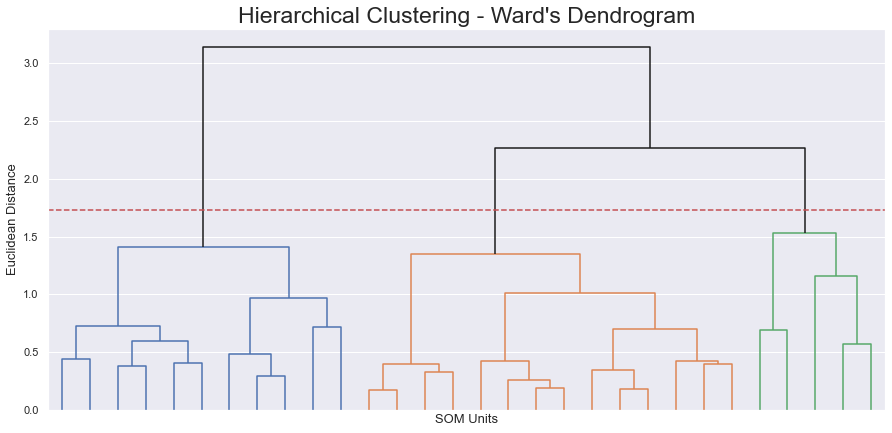

In [235]:
#Select variables
indicators =   ['Access to electricity, urban (% of urban population)',
                'Agricultural land (% of land area)',
                'Access to electricity (% of population)',
                'GDP (current US$)',
                'Land area (sq. km)',
                'Population, total',
                #'Adjusted savings: energy depletion (current US$)',
                'Renewable energy consumption (% of total final energy consumption)']

select_data = wdi_scaled[indicators]

kmeans_Hierarchical(select_data,0.55)

According to the dendogram, the number of cluster is 3. We are going to do a Kmeans with this K

In [236]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(select_data)
cluster2019 = select_data.copy()
cluster2019['Cluster'] = pd.Series(kmeans.labels_,index=select_data.index)
cluster2019 = pd.concat([cluster2019,wdi_scaled[['Dualcit_grouped']]],axis=1)

print(cluster2019.Dualcit_grouped.value_counts())

#create a column for each duacit_grouped
cluster2019 = pd.concat([cluster2019,pd.get_dummies(cluster2019.Dualcit_grouped)],axis=1)
cluster2019.drop('Dualcit_grouped',inplace=True,axis=1)

#Agreggate
cluster2019_agg_ind = cluster2019[indicators+['Cluster']].groupby("Cluster").mean()
cluster2019_agg_duacit = cluster2019[[1.0,2.0,3.0,'Cluster']].groupby("Cluster").sum()
pd.concat([cluster2019_agg_ind,cluster2019_agg_duacit],axis=1)

2.00    120
1.00     46
3.00     18
Name: Dualcit_grouped, dtype: int64


,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),1.0,2.0,3.0
Cluster,,,,,,,,,,
0,0.98,0.66,0.96,0.04,0.04,0.05,0.21,17,49,9
1,0.99,0.22,0.96,0.01,0.05,0.02,0.25,15,48,6
2,0.66,0.59,0.36,0.01,0.03,0.02,0.75,14,23,3


### Kprototype

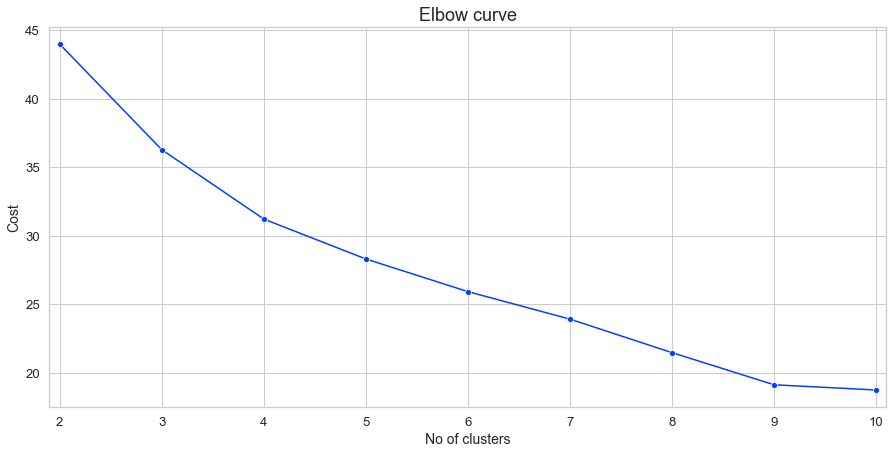

In [237]:
# Plotting elbow curve for k=2 to k=10
selected_clusters = pd.concat([select_data,wdi_scaled[['Dualcit_grouped']]],axis=1)

plot_elbow_curve(2,10,selected_clusters)

In [238]:
Kpro_cluster = KPrototypes(n_jobs = -1,n_clusters=9, init='Huang', random_state=42)
kpro_labels = Kpro_cluster.fit_predict(selected_clusters, categorical=[7])

wdi_scaled.iloc[:,:-1] = scaler.inverse_transform(wdi_scaled.iloc[:,:-1])

selected_clusters = pd.concat([wdi_scaled[indicators],pd.get_dummies(selected_clusters.Dualcit_grouped)],axis=1)
selected_clusters['clusters'] = kpro_labels

final_clusters = pd.concat([selected_clusters.groupby('clusters').mean(),
                           selected_clusters.groupby('clusters').size()
                          ],axis=1)

final_clusters.rename({0:'N_Countries'},inplace=True,axis=1)
final_clusters

,"Access to electricity, urban (% of urban population)",Agricultural land (% of land area),Access to electricity (% of population),GDP (current US$),Land area (sq. km),"Population, total",Renewable energy consumption (% of total final energy consumption),1.0,2.0,3.0,N_Countries
clusters,,,,,,,,,,,
0,93.10,14.95,79.44,72512248038.46,364074.82,23869932.20,73.16,0.80,0.20,0.00,10
1,99.29,47.07,95.92,172406071395.26,481950.50,23122224.07,25.72,0.00,0.00,1.00,14
2,78.16,59.41,47.02,35480499886.42,416242.03,23101114.64,69.10,0.11,0.81,0.07,27
3,47.24,33.33,24.12,678914520257.93,696330.74,24150872.18,75.47,0.64,0.27,0.09,11
4,98.88,10.43,92.56,834942745390.91,281857.78,22445921.22,6.73,0.89,0.00,0.11,9
5,98.97,52.74,98.61,338644761724.41,391937.78,20522644.85,18.55,0.00,1.00,0.00,46
6,99.48,19.36,97.98,210460373699.39,985745.79,19083903.37,19.21,0.00,1.00,0.00,46
7,100.00,53.40,99.27,12861222087049.49,7181770.97,1030820903.00,17.42,0.67,0.33,0.00,3
8,97.52,49.87,90.89,545176219702.97,568568.14,56554085.11,24.50,1.00,0.00,0.00,18


In [240]:
selected_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, AFG to ZWE
Data columns (total 11 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Access to electricity, urban (% of urban population)                184 non-null    float64
 1   Agricultural land (% of land area)                                  184 non-null    float64
 2   Access to electricity (% of population)                             184 non-null    float64
 3   GDP (current US$)                                                   184 non-null    float64
 4   Land area (sq. km)                                                  184 non-null    float64
 5   Population, total                                                   184 non-null    float64
 6   Renewable energy consumption (% of total final energy consumption)  184 non-null    float64
 7   1.0                 

In [ ]:
1. umap
2. grafico de barras
3. heatmap tabela
5. pesquisar valores de mapa

In [ ]:
# Original code: https://antonsruberts.github.io/kproto-audience/
# changed some parts to fit the new umap version and as a part of debugging some lines.

#Preprocessing numerical
numerical = selected_clusters.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer('yeo-johnson') # Yeo-Johnson by default, but specified to avoid confusion
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = selected_clusters.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, densmap=False, densmap_kwds={}, output_dens=False)

embedding = embedding[0]
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

# Merging the tables

In [238]:
def merge_tables(df,indicator_name):
    
    wdi_indicator = wdi.loc[wdi['Indicator Name']==indicator_name].set_index('Country Code').T.iloc[3:-1,:].reset_index()
    wdi_indicator['index'] = wdi_indicator['index'].astype(int)
    wdi_indicator = wdi_indicator.loc[wdi_indicator['index']>=2000]
    
    year = np.array([])
    ISOCODE = np.array([])
    value =  np.array([])
    
    for ISO in wdi_indicator.columns[1:-1]:
        ISOCODE_ = np.full((len(wdi_indicator),),ISO)
        ISOCODE = np.append(ISOCODE,ISOCODE_)
        
        year = np.append(year,wdi_indicator['index'].values)
        value = np.append(value,wdi_indicator[ISO].values)

        
    ISOCODE_SER = pd.Series(ISOCODE)
    year_ser = pd.Series(year)
    value = pd.Series(value).astype(float)
    final_wdi = pd.DataFrame([ISOCODE_SER,year_ser,value]).T.rename(columns={0:'ISO3',1:'Year',2:indicator_name})
    final_wdi['Year'] = final_wdi['Year'].astype(int)
    df_merge = df.merge(final_wdi, right_on=['ISO3','Year'],left_on = ['ISO3','Year'] )
    return   df_merge
    

In [239]:
#create a list of indicators names to merge with the dual cit base

df_merge = df.copy()
for ind in Indicator_little_nan[0:2]:
    df_merge = merge_tables(df_merge,ind)